In [1]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from src import config as cfg

sns.set_theme(style="whitegrid")


## Load and Prepare Data

In [3]:
# load the final dataset
final_data_path = cfg.FIN_MERGED / "model_ready_dataset.parquet"
print(f"loading final dataset from: {final_data_path}")
df = pd.read_parquet(final_data_path)

# drop rows where either target is null
df_clean = df.dropna(subset=['NO2', 'PM2.5']).copy()
df_clean['date'] = pd.to_datetime(df_clean['date'], utc=True)

# ensure data is sorted correctly for time-series operations
df_clean = df_clean.sort_values(['site_code', 'date'])
print(f"data prepared for modeling. shape: {df_clean.shape}")


loading final dataset from: D:\Air pollution london\data\final\aq_traffic\model_ready_dataset.parquet
data prepared for modeling. shape: (499571, 29)


In [4]:
# look at the 0.1% and 99.9% percentiles
for col in ['NO2','PM2.5','aadf_vehicle_count','wind_speed_10m']:
    if col in df_clean.columns:
        lo, hi = df_clean[col].quantile([0.001, 0.999])
        print(f"{col}: {lo:.2f} to {hi:.2f}")


NO2: -1.00 to 135.90
PM2.5: -1.70 to 76.00
aadf_vehicle_count: 1864.00 to 50808.00
wind_speed_10m: 0.80 to 44.34


In [5]:
# remove negative pollution
df_clean['NO2']   = df_clean['NO2'].clip(lower=0)
df_clean['PM2.5'] = df_clean['PM2.5'].clip(lower=0)

# cap extreme winds at the 99.5th percentile
if 'wind_speed_10m' in df_clean.columns:
    df_clean['wind_speed_10m'] = df_clean['wind_speed_10m'].clip(upper=25)
if 'wind_gusts_10m' in df_clean.columns:
    df_clean['wind_gusts_10m'] = df_clean['wind_gusts_10m'].clip(upper=30)


## Feature Engineering
#### This cell creates the lagged feature and a ULEZ indicator feature that will be used by the models

In [7]:
# Create lagged features on the cleaned dataframe
df_clean['NO2_lag24h']  = df_clean.groupby('site_code')['NO2'].shift(24)
df_clean['PM2.5_lag24h']= df_clean.groupby('site_code')['PM2.5'].shift(24)

df_clean['NO2_lag12h']  = df_clean.groupby('site_code')['NO2'].shift(12)
df_clean['PM2.5_lag12h']= df_clean.groupby('site_code')['PM2.5'].shift(12)

# add ulez and lockdown period
ulez_start_date = pd.to_datetime('2019-04-08', utc=True)
df_clean['is_ulez']     = (df_clean['date'] >= ulez_start_date).astype(int)
df_clean['is_lockdown'] = df_clean['date'].between('2020-03-23','2021-12-29').astype(int)

# drop rows that became NaN due to lags
df_clean = df_clean.dropna(subset=['NO2_lag12h','NO2_lag24h','PM2.5_lag12h','PM2.5_lag24h'])

print("Feature engineering complete.")


Feature engineering complete.


## Common Tuning Parameters
#### This cell defines the hyperparameter search space and cross-validation strategy, which are common to all models.

In [10]:
# Hyperparameter distribution for LightGBM RandomizedSearchCV
param_dist = {
    'n_estimators':        [300, 600, 1000],
    'learning_rate':       [0.03, 0.05, 0.08],
    'num_leaves':         [31, 63, 127],
    'min_data_in_leaf':   [20, 50, 100],
    'subsample':          [0.7, 0.8, 0.9],   # bagging_fraction
    'colsample_bytree':   [0.7, 0.8, 0.9],   # feature_fraction
    'reg_lambda':         [0.0, 0.5, 1.0, 2.0]
}

# time series cross validation strategy
tscv = TimeSeriesSplit(n_splits=5)

print("Common tuning parameters defined for LightGBM.")


Common tuning parameters defined for LightGBM.


## Model 1: Bexley & Greenwich (BX2, GN0)
#### Model 1 - Data Preparation

In [17]:
sites_1 = ['BX2', 'GN0']
df_1 = df_clean[df_clean['site_code'].isin(sites_1)].copy()
df_1.sort_values('date', inplace=True)

# Drop rows with NaNs created by the shift operations
df_1.dropna(inplace=True)

# Define features and targets
targets = ['NO2', 'PM2.5']
# Baseline excludes some flags/lags
features_1 = [col for col in df_1.columns if col not in targets + 
              ['date', 'site_code', 'site_name','is_ulez', 
               'is_weekend', 'is_holiday', 'is_lockdown','NO2_lag24h',
               'PM2.5_lag24h', 'NO2_lag12h', 'PM2.5_lag12h']]

X1 = df_1[features_1]
y1 = df_1[targets]

# Time based split for Model 1
split_date_1 = '2024-01-01'
train_mask_1 = df_1['date'] < split_date_1
test_mask_1 = df_1['date'] >= split_date_1
X1_train, X1_test = X1[train_mask_1], X1[test_mask_1]
y1_train, y1_test = y1[train_mask_1], y1[test_mask_1]

print(f"Model 1 data ready. Training shape: {X1_train.shape}, Test shape: {X1_test.shape}")


Model 1 data ready. Training shape: (240982, 22), Test shape: (25877, 22)


#### Model 1 - Baseline Training & Evaluation

Training Baseline Model 1 (LightGBM) ... 
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2149
[LightGBM] [Info] Number of data points in the train set: 240982, number of used features: 20
[LightGBM] [Info] Start training from score 29.902369
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018692 seconds.
You can set `force_col

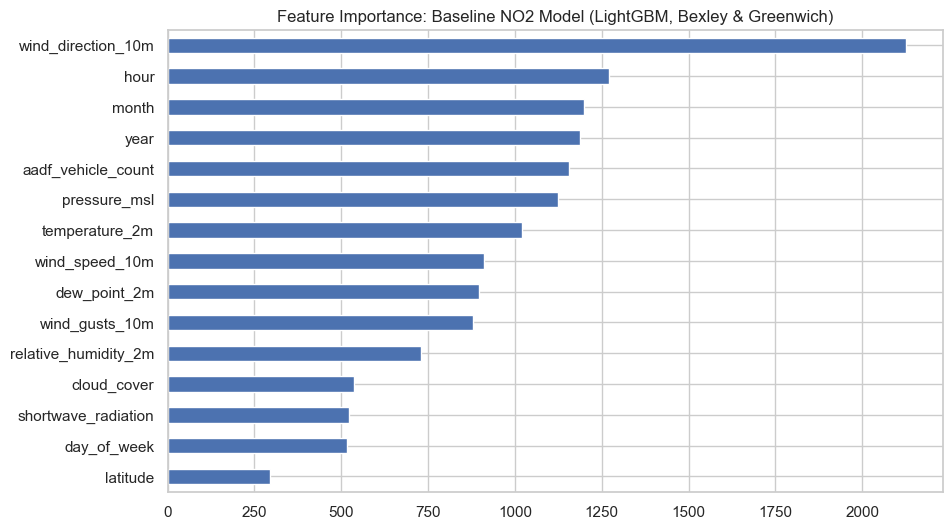

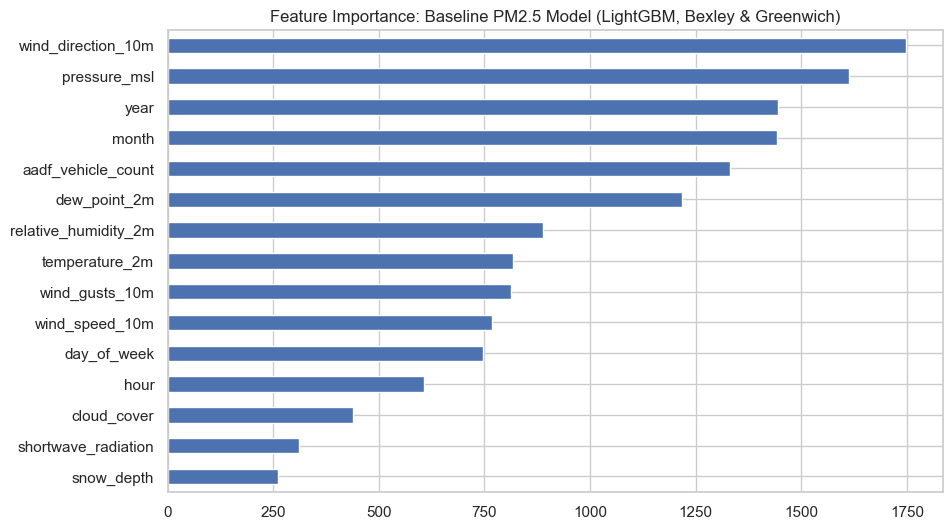

In [20]:
print("Training Baseline Model 1 (LightGBM) ... ")

# Baseline LightGBM with defaults
lgb_baseline_no2_1 = LGBMRegressor(
    n_estimators=500, learning_rate=0.05, num_leaves=31,
    min_data_in_leaf=50, subsample=0.8, colsample_bytree=0.8,
    reg_lambda=1.0, random_state=42, n_jobs=-1
)
lgb_baseline_no2_1.fit(X1_train, y1_train['NO2'])

lgb_baseline_pm25_1 = LGBMRegressor(
    n_estimators=500, learning_rate=0.05, num_leaves=31,
    min_data_in_leaf=50, subsample=0.8, colsample_bytree=0.8,
    reg_lambda=1.0, random_state=42, n_jobs=-1
)
lgb_baseline_pm25_1.fit(X1_train, y1_train['PM2.5'])

print("Baseline models training complete.")

# Evaluate models
print("\nEvaluating Baseline Model 1 (LightGBM): ")
y_pred_no2_1 = lgb_baseline_no2_1.predict(X1_test)
y_pred_pm25_1 = lgb_baseline_pm25_1.predict(X1_test)

r2_no2_1 = r2_score(y1_test['NO2'], y_pred_no2_1)
r2_pm25_1 = r2_score(y1_test['PM2.5'], y_pred_pm25_1)
mae_no2_1 = mean_absolute_error(y1_test['NO2'], y_pred_no2_1)
mae_pm25_1 = mean_absolute_error(y1_test['PM2.5'], y_pred_pm25_1)

print(f"NO2 R-squared: {r2_no2_1:.3f}")
print(f"PM2.5 R-squared: {r2_pm25_1:.3f}")
print(f"NO2 MAE: {mae_no2_1:.3f}")
print(f"PM2.5 MAE: {mae_pm25_1:.3f}")

# Feature Importance for NO2 Model
importances_no2 = pd.Series(lgb_baseline_no2_1.feature_importances_, index=X1_train.columns).nlargest(15)
plt.figure(figsize=(10, 6))
importances_no2.sort_values().plot.barh()
plt.title('Feature Importance: Baseline NO2 Model (LightGBM, Bexley & Greenwich)')
plt.show()

# Feature Importance for PM2.5 Model
importances_pm25 = pd.Series(lgb_baseline_pm25_1.feature_importances_, index=X1_train.columns).nlargest(15)
plt.figure(figsize=(10, 6))
importances_pm25.sort_values().plot.barh()
plt.title('Feature Importance: Baseline PM2.5 Model (LightGBM, Bexley & Greenwich)')
plt.show()


#### Model 1 - Hyperparameter Tuning & Final Model

In [30]:
# Define features and targets to include all engineered features
features_1 = [col for col in df_1.columns if col not in targets + ['date', 'site_code', 'site_name']]
X1 = df_1[features_1]

# Time-based split for Model 1
train_mask_1 = df_1['date'] < split_date_1
test_mask_1 = df_1['date'] >= split_date_1
X1_train, X1_test = X1[train_mask_1], X1[test_mask_1]
y1_train, y1_test = y1[train_mask_1], y1[test_mask_1]

print("\nTuning Hyperparameters for NO2 (Model 1, LightGBM) ... ")
lgb_no2_1 = LGBMRegressor(random_state=42, n_jobs=-1)
random_search_no2_1 = RandomizedSearchCV(
    estimator=lgb_no2_1, param_distributions=param_dist,
    n_iter=12, cv=tscv, scoring='r2', n_jobs=-1, random_state=42, verbose=2
)
random_search_no2_1.fit(X1_train, y1_train['NO2'])

dates_train = df_1[train_mask_1]['date'].reset_index(drop=True)

# Print individual fold scores
print("\nIndividual Fold R2 Scores for Best NO2 Model (LightGBM):")
results_no2 = random_search_no2_1.cv_results_
best_index_no2 = random_search_no2_1.best_index_
for i, (train_idx, test_idx) in enumerate(tscv.split(dates_train), start=1):
    te = dates_train.iloc[test_idx]
    dr_min, dr_max = te.min().date(), te.max().date()
    fold_score = results_no2[f'split{i-1}_test_score'][best_index_no2]
    print(f"Fold {i} (Date Range: {dr_min} to {dr_max}): R-squared = {fold_score:.3f}")

print("\nBest parameters found for NO2:", random_search_no2_1.best_params_)
best_params_no2_1 = random_search_no2_1.best_params_

print("\nTuning Hyperparameters for PM2.5 (Model 1, LightGBM) ... ")
lgb_pm25_1 = LGBMRegressor(random_state=42, n_jobs=-1)
random_search_pm25_1 = RandomizedSearchCV(
    estimator=lgb_pm25_1, param_distributions=param_dist,
    n_iter=12, cv=tscv, scoring='r2', n_jobs=-1, random_state=42, verbose=2
)
random_search_pm25_1.fit(X1_train, y1_train['PM2.5'])

print("\nIndividual Fold R2 Scores for Best PM2.5 Model (LightGBM):")
results_pm25 = random_search_pm25_1.cv_results_
best_index_pm25 = random_search_pm25_1.best_index_
for i, (train_idx, test_idx) in enumerate(tscv.split(dates_train), start=1):
    te = dates_train.iloc[test_idx]
    dr_min, dr_max = te.min().date(), te.max().date()
    fold_score = results_pm25[f'split{i-1}_test_score'][best_index_pm25]
    print(f"Fold {i} (Date Range: {dr_min} to {dr_max}): R-squared = {fold_score:.3f}")

print("\nBest parameters found for PM2.5:", random_search_pm25_1.best_params_)
best_params_pm25_1 = random_search_pm25_1.best_params_

print("\nTraining Final Tuned Models for Model 1 (LightGBM) ... ")
final_no2_model_1 = LGBMRegressor(**best_params_no2_1, random_state=42, n_jobs=-1)
final_no2_model_1.fit(X1_train, y1_train['NO2'])
final_pm25_model_1 = LGBMRegressor(**best_params_pm25_1, random_state=42, n_jobs=-1)
final_pm25_model_1.fit(X1_train, y1_train['PM2.5'])
print("Final tuned models trained.")

# Evaluate models on test data
y_pred_no2_1 = final_no2_model_1.predict(X1_test)
y_pred_pm25_1 = final_pm25_model_1.predict(X1_test)
y_pred_tuned_df_1 = pd.DataFrame({'NO2': y_pred_no2_1, 'PM2.5': y_pred_pm25_1}, index=y1_test.index)

r2_no2_tuned_1 = r2_score(y1_test['NO2'], y_pred_tuned_df_1['NO2'])
r2_pm25_tuned_1 = r2_score(y1_test['PM2.5'], y_pred_tuned_df_1['PM2.5'])
print(f"Tuned NO2 R-squared: {r2_no2_tuned_1:.3f}")
print(f"Tuned PM2.5 R-squared: {r2_pm25_tuned_1:.3f}")

mae_no2_tuned_1 = mean_absolute_error(y1_test['NO2'], y_pred_tuned_df_1['NO2'])
mae_pm25_tuned_1 = mean_absolute_error(y1_test['PM2.5'], y_pred_tuned_df_1['PM2.5'])
print(f"Tuned NO2 MAE: {mae_no2_tuned_1:.3f}")
print(f"Tuned PM2.5 MAE: {mae_pm25_tuned_1:.3f}")

# evaluate models on training data
print("\n Evaluating Tuned Models on TRAINING DATA (Model 1, LightGBM) ...")
y_pred_train_no2_1 = final_no2_model_1.predict(X1_train)
y_pred_train_pm25_1 = final_pm25_model_1.predict(X1_train)

r2_no2_train_1 = r2_score(y1_train['NO2'], y_pred_train_no2_1)
r2_pm25_train_1 = r2_score(y1_train['PM2.5'], y_pred_train_pm25_1)
mae_no2_train_1 = mean_absolute_error(y1_train['NO2'], y_pred_train_no2_1)
mae_pm25_train_1 = mean_absolute_error(y1_train['PM2.5'], y_pred_train_pm25_1)

print(f"Training NO2 R-squared: {r2_no2_train_1:.3f}")
print(f"Training PM2.5 R-squared: {r2_pm25_train_1:.3f}")
print(f"Training NO2 MAE: {mae_no2_train_1:.3f}")
print(f"Training PM2.5 MAE: {mae_pm25_train_1:.3f}")



Tuning Hyperparameters for NO2 (Model 1, LightGBM) ... 
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3177
[LightGBM] [Info] Number of data points in the train set: 240982, number of used features: 28
[LightGBM] [Info] Start training from score 29.902369

Individual Fold R2 Scores for Best NO2 Model (LightGBM):
Fold 1 (Date Range: 2012-05-11 to 2014-09-09): R-squared = 0.719
Fold 2 (Date Range: 2014-09-09 to 2017-01-07): R-squared = 0.727
Fold 3 (Date Range: 2017-01-07 to 2019-05-05): R-squared = 0.653
Fold 4 (Date Range: 2019-05-05 to 202

#### Model 1 Manual tuning to reduce overfitting

In [31]:
print("Manually Tuning Model 1 (LightGBM) for NO2 ...")

# Copy best params from tuning
manual_params_no2_1 = best_params_no2_1.copy()
manual_params_pm25_1 = best_params_pm25_1.copy()  # PM2.5 unchanged (not overfitting)


manual_params_no2_1['max_depth']        = 9      # cap tree depth
manual_params_no2_1['num_leaves']       = 45     # simpler leaves than 63
manual_params_no2_1['min_data_in_leaf'] = 320    # larger leaves
manual_params_no2_1['reg_lambda']       = 3    # L2 regularisation
manual_params_no2_1['reg_alpha']        = 0.3    # L1 regularisation
manual_params_no2_1['min_split_gain']   = 0.1    # require useful splits
manual_params_no2_1['subsample']        = 0.8    # bagging
manual_params_no2_1['subsample_freq']   = 1      # enable bagging each iteration
manual_params_no2_1['colsample_bytree'] = 0.8    # feature subsample
manual_params_no2_1['n_estimators'] = 600    
manual_params_no2_1['min_child_weight'] = 7.0
# Re-train NO2 model with manual anti-overfitting params
manual_no2_model_1 = LGBMRegressor(**manual_params_no2_1, random_state=42, n_jobs=-1)
manual_no2_model_1.fit(X1_train, y1_train['NO2'])

# PM2.5 model: use hypertuned params (unchanged)
manual_pm25_model_1 = LGBMRegressor(**manual_params_pm25_1, random_state=42, n_jobs=-1)
manual_pm25_model_1.fit(X1_train, y1_train['PM2.5'])

print("Manual tuning complete.")

# Evaluate on test data
y_pred_no2_1  = manual_no2_model_1.predict(X1_test)
y_pred_pm25_1 = manual_pm25_model_1.predict(X1_test)
r2_no2_test   = r2_score(y1_test['NO2'], y_pred_no2_1)
r2_pm25_test  = r2_score(y1_test['PM2.5'], y_pred_pm25_1)
print(f"Test NO2 R-squared: {r2_no2_test:.3f}")
print(f"Test PM2.5 R-squared: {r2_pm25_test:.3f}")

mae_no2_test  = mean_absolute_error(y1_test['NO2'], y_pred_no2_1)
mae_pm25_test = mean_absolute_error(y1_test['PM2.5'], y_pred_pm25_1)
print(f"Test NO2 MAE: {mae_no2_test:.3f}")
print(f"Test PM2.5 MAE: {mae_pm25_test:.3f}")


# Evaluate on training data
y_pred_train_no2_1  = manual_no2_model_1.predict(X1_train)
y_pred_train_pm25_1 = manual_pm25_model_1.predict(X1_train)
r2_no2_train        = r2_score(y1_train['NO2'], y_pred_train_no2_1)
r2_pm25_train       = r2_score(y1_train['PM2.5'], y_pred_train_pm25_1)
print(f"Training NO2 R-squared: {r2_no2_train:.3f}")
print(f"Training PM2.5 R-squared: {r2_pm25_train:.3f}")

mae_no2_train = mean_absolute_error(y1_train['NO2'], y_pred_train_no2_1)
mae_pm25_train = mean_absolute_error(y1_train['PM2.5'], y_pred_train_pm25_1)
print(f"Training NO2 MAE: {mae_no2_train:.3f}")
print(f"Training PM2.5 MAE: {mae_pm25_train:.3f}")


Manually Tuning Model 1 (LightGBM) for NO2 ...
[LightGBM] [Warning] min_data_in_leaf is set=320, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=320
[LightGBM] [Warning] min_data_in_leaf is set=320, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3177
[LightGBM] [Info] Number of data points in the train set: 240982, number of used features: 28
[LightGBM] [Info] Start training from score 29.902369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_sa

## Model 2: Camden & Hackney (BL0, HK6)
#### Model 2 - Data Preparation

In [34]:
sites_2 = ['BL0', 'HK6']
df_2 = df_clean[df_clean['site_code'].isin(sites_2)].copy()
df_2.sort_values('date', inplace=True)

# Drop rows with NaNs created by the shift operations
df_2.dropna(inplace=True)

# Define features and targets
targets = ['NO2', 'PM2.5']
features_2 = [col for col in df_2.columns if col not in targets + ['date', 'site_code', 'site_name','is_ulez', 
               'is_weekend', 'is_holiday', 'is_lockdown','NO2_lag24h',
               'PM2.5_lag24h', 'NO2_lag12h', 'PM2.5_lag12h']]
X2 = df_2[features_2]
y2 = df_2[targets]

# Time based split for Model 2
split_date_2 = '2022-01-01'
train_mask_2 = df_2['date'] < split_date_2
dates_train2 = df_2[train_mask_2]['date'].reset_index(drop=True)
test_mask_2 = df_2['date'] >= split_date_2
X2_train, X2_test = X2[train_mask_2], X2[test_mask_2]
y2_train, y2_test = y2[train_mask_2], y2[test_mask_2]

print(f"Model 2 data ready. Training shape: {X2_train.shape}, Test shape: {X2_test.shape}")


Model 2 data ready. Training shape: (206227, 22), Test shape: (26389, 22)


#### Model 2 - Baseline Training & Evaluation

Training Baseline Model 2 (LightGBM) ...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2140
[LightGBM] [Info] Number of data points in the train set: 206227, number of used features: 22
[LightGBM] [Info] Start training from score 48.739649
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2140
[LightGBM] [Info] Number of data points in the train set: 206227, number of used features: 22
[LightGBM] [Info] Start training from score 12.353747
Baseline models training complete.
Evaluating Baseline Model 2 ...
NO2 R-squared: 0.560
PM2.5 R-squared: 0.182
NO2 MAE: 8.332
PM2.5 MAE: 3.677


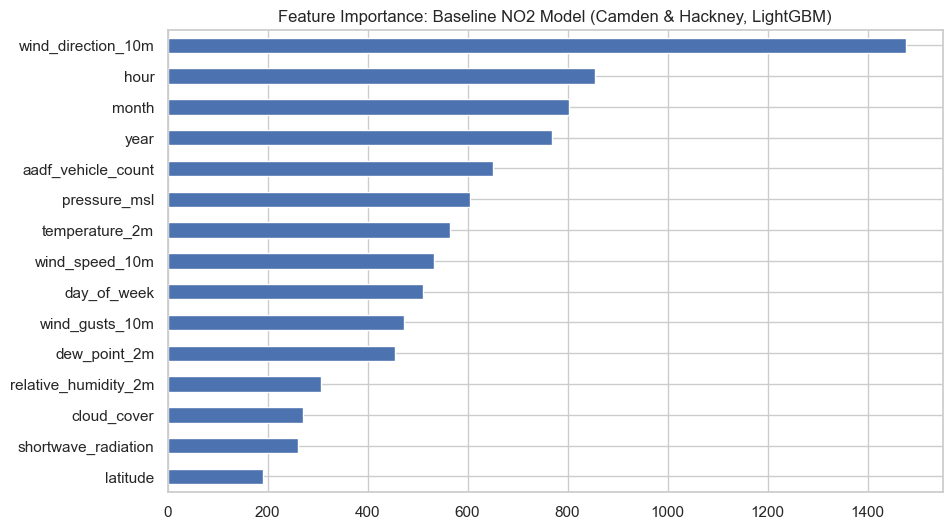

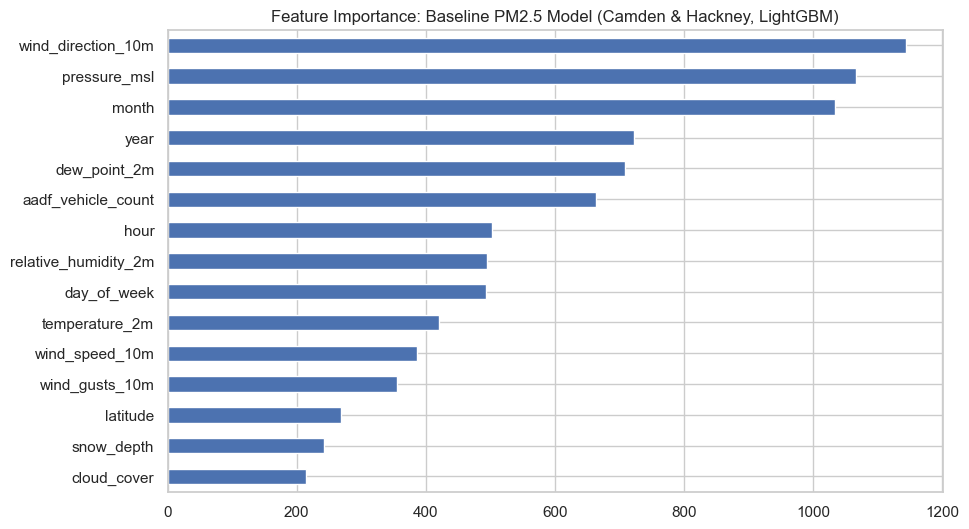

In [36]:
print("Training Baseline Model 2 (LightGBM) ...")

# Keep baseline simple and fast
lgb_baseline_params = dict(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,            # no cap for baseline
    subsample=1.0,
    colsample_bytree=1.0,
    random_state=42,
    n_jobs=-1
)

# Train NO2 model
lgb_base_no2_2 = LGBMRegressor(**lgb_baseline_params)
lgb_base_no2_2.fit(X2_train, y2_train['NO2'])

# Train PM2.5 model
lgb_base_pm25_2 = LGBMRegressor(**lgb_baseline_params)
lgb_base_pm25_2.fit(X2_train, y2_train['PM2.5'])

print("Baseline models training complete.\nEvaluating Baseline Model 2 ...")

# Evaluate
y_pred_no2_2 = lgb_base_no2_2.predict(X2_test)
y_pred_pm25_2 = lgb_base_pm25_2.predict(X2_test)

r2_no2_2  = r2_score(y2_test['NO2'], y_pred_no2_2)
r2_pm25_2 = r2_score(y2_test['PM2.5'], y_pred_pm25_2)
mae_no2_2  = mean_absolute_error(y2_test['NO2'], y_pred_no2_2)
mae_pm25_2 = mean_absolute_error(y2_test['PM2.5'], y_pred_pm25_2)

print(f"NO2 R-squared: {r2_no2_2:.3f}")
print(f"PM2.5 R-squared: {r2_pm25_2:.3f}")
print(f"NO2 MAE: {mae_no2_2:.3f}")
print(f"PM2.5 MAE: {mae_pm25_2:.3f}")

# Feature importance plots (top 15)
importances_no2_2 = pd.Series(lgb_base_no2_2.feature_importances_, index=X2_train.columns).nlargest(15)
plt.figure(figsize=(10, 6))
importances_no2_2.sort_values().plot.barh()
plt.title('Feature Importance: Baseline NO2 Model (Camden & Hackney, LightGBM)')
plt.show()

importances_pm25_2 = pd.Series(lgb_base_pm25_2.feature_importances_, index=X2_train.columns).nlargest(15)
plt.figure(figsize=(10, 6))
importances_pm25_2.sort_values().plot.barh()
plt.title('Feature Importance: Baseline PM2.5 Model (Camden & Hackney, LightGBM)')
plt.show()


#### Model 2 - Hyperparameter Tuning & Final Model

In [38]:
# Full feature set
features_2 = [col for col in df_2.columns if col not in targets + ['date', 'site_code', 'site_name']]
X2 = df_2[features_2]

# Time based split
X2_train, X2_test = X2[train_mask_2], X2[test_mask_2]
y2_train, y2_test = y2[train_mask_2], y2[test_mask_2]

print("\nTuning Hyperparameters for NO2 (Model 2, LightGBM) ... ")
lgb_no2_2 = LGBMRegressor(random_state=42, n_jobs=-1)
random_search_no2_2 = RandomizedSearchCV(
    estimator=lgb_no2_2, param_distributions=param_dist,
    n_iter=12, cv=tscv, scoring='r2', n_jobs=-1, random_state=42, verbose=2
)
random_search_no2_2.fit(X2_train, y2_train['NO2'])

# Individual fold scores
print("\nIndividual Fold R2 Scores for Best NO2 Model (Model 2, LightGBM):")
results_no2_2 = random_search_no2_2.cv_results_
best_index_no2_2 = random_search_no2_2.best_index_
for i, (train_idx, test_idx) in enumerate(tscv.split(dates_train2), start=1):
    te = dates_train2.iloc[test_idx]
    dr_min, dr_max = te.min().date(), te.max().date()
    fold_score = results_no2_2[f'split{i-1}_test_score'][best_index_no2_2]
    print(f"Fold {i} (Date Range: {dr_min} to {dr_max}): R-squared = {fold_score:.3f}")

print("\nBest parameters found for NO2:", random_search_no2_2.best_params_)
best_params_no2_2 = random_search_no2_2.best_params_

print("\nTuning Hyperparameters for PM2.5 (Model 2, LightGBM) ... ")
lgb_pm25_2 = LGBMRegressor(random_state=42, n_jobs=-1)
random_search_pm25_2 = RandomizedSearchCV(
    estimator=lgb_pm25_2, param_distributions=param_dist,
    n_iter=12, cv=tscv, scoring='r2', n_jobs=-1, random_state=42, verbose=2
)
random_search_pm25_2.fit(X2_train, y2_train['PM2.5'])

print("\nIndividual Fold R2 Scores for Best PM2.5 Model (Model 2, LightGBM):")
results_pm25_2 = random_search_pm25_2.cv_results_
best_index_pm25_2 = random_search_pm25_2.best_index_
for i, (train_idx, test_idx) in enumerate(tscv.split(dates_train2), start=1):
    te = dates_train2.iloc[test_idx]
    dr_min, dr_max = te.min().date(), te.max().date()
    fold_score = results_pm25_2[f'split{i-1}_test_score'][best_index_pm25_2]
    print(f"Fold {i} (Date Range: {dr_min} to {dr_max}): R-squared = {fold_score:.3f}")

print("\nBest parameters found for PM2.5:", random_search_pm25_2.best_params_)
best_params_pm25_2 = random_search_pm25_2.best_params_

# Train final tuned models
print("\nTraining Final Tuned Models for Model 2 (LightGBM) ... ")
final_no2_model_2 = LGBMRegressor(**best_params_no2_2, random_state=42, n_jobs=-1)
final_no2_model_2.fit(X2_train, y2_train['NO2'])

final_pm25_model_2 = LGBMRegressor(**best_params_pm25_2, random_state=42, n_jobs=-1)
final_pm25_model_2.fit(X2_train, y2_train['PM2.5'])
print("Final tuned models trained.")

# Evaluate tuned models on TEST
print("\nEvaluating Tuned Models for Model 2 (LightGBM) ... ")
y_pred_no2_2  = final_no2_model_2.predict(X2_test)
y_pred_pm25_2 = final_pm25_model_2.predict(X2_test)

r2_no2_tuned_2  = r2_score(y2_test['NO2'],  y_pred_no2_2)
r2_pm25_tuned_2 = r2_score(y2_test['PM2.5'], y_pred_pm25_2)
mae_no2_tuned_2  = mean_absolute_error(y2_test['NO2'],  y_pred_no2_2)
mae_pm25_tuned_2 = mean_absolute_error(y2_test['PM2.5'], y_pred_pm25_2)

print(f"Tuned NO2 R-squared: {r2_no2_tuned_2:.3f}")
print(f"Tuned PM2.5 R-squared: {r2_pm25_tuned_2:.3f}")
print(f"Tuned NO2 MAE: {mae_no2_tuned_2:.3f}")
print(f"Tuned PM2.5 MAE: {mae_pm25_tuned_2:.3f}")

# Evaluate tuned models on TRAIN
print("\nEvaluating Tuned Models on TRAINING DATA (Model 2, LightGBM) ... ")
y_pred_train_no2_2  = final_no2_model_2.predict(X2_train)
y_pred_train_pm25_2 = final_pm25_model_2.predict(X2_train)

r2_no2_train_2  = r2_score(y2_train['NO2'],  y_pred_train_no2_2)
r2_pm25_train_2 = r2_score(y2_train['PM2.5'], y_pred_train_pm25_2)
mae_no2_train_2  = mean_absolute_error(y2_train['NO2'],  y_pred_train_no2_2)
mae_pm25_train_2 = mean_absolute_error(y2_train['PM2.5'], y_pred_train_pm25_2)

print(f"Training NO2 R-squared: {r2_no2_train_2:.3f}")
print(f"Training PM2.5 R-squared: {r2_pm25_train_2:.3f}")
print(f"Training NO2 MAE: {mae_no2_train_2:.3f}")
print(f"Training PM2.5 MAE: {mae_pm25_train_2:.3f}")



Tuning Hyperparameters for NO2 (Model 2, LightGBM) ... 
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3168
[LightGBM] [Info] Number of data points in the train set: 206227, number of used features: 30
[LightGBM] [Info] Start training from score 48.739649

Individual Fold R2 Scores for Best NO2 Model (Model 2, LightGBM):
Fold 1 (Date Range: 2012-01-01 to 2013-12-30): R-squared = 0.670
Fold 2 (Date Range: 2013-12-30 to 2015-12-29): R-squared = 0.661
Fold 3 (Date Range: 2015-12-29 to 2017-12-26): R-squared = 0.583
Fold 4 (Date Range: 2017-12-26 t